In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import sys
import matplotlib.pyplot as plt

In [10]:
model = load_model("GOAT.h5") # modello

_, h, w, _ = model.input_shape

# mapping numeri-classi
class_names = [
    "Erlang/Rayleigh",
    "Gaussian",
    "Original",
    "Periodic",
    "Salt & Pepper",
    "Speckle",
    "Striping Horizontal",
    "Striping Vertical",
    "Uniform"
]

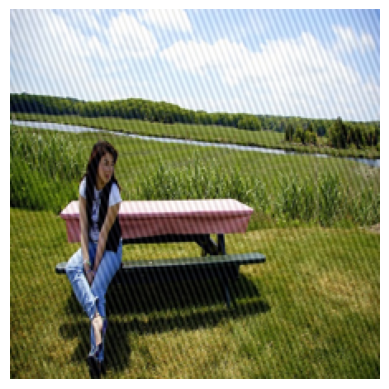

In [15]:
image_path = "park.jpg" # user input

img = Image.open(image_path).convert("RGB").resize((w, h))
arr = np.array(img).astype("float32") / 255.0
arr = np.expand_dims(arr, axis=0) # Aggiungo la dimensione batch: (1, h, w, 3)

plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
# Predizione modello
probs = model.predict(arr).flatten()
idx_sorted = np.argsort(probs)
top3_idx = np.argsort(probs)[-3:][::-1]

print("Top 3 predictions with confidence:")
for rank, idx in enumerate(top3_idx, start=1):
    print(f"{rank}. {class_names[idx]} → {probs[idx]:.4f}")

top1 = top3_idx[0]
conf1 = probs[top1]

THRESHOLD = 0.9

if conf1 >= THRESHOLD:
    chosen_idx = top1
    chosen_conf = conf1
    reason = f"conf. massima ({conf1:.2f} ≥ {THRESHOLD})"
else:
    # qualsiasi cosa abbia predetto "sotto soglia" → Original
    chosen_idx = class_names.index("Original")
    chosen_conf = probs[chosen_idx]
    reason = f"conf. massima ({conf1:.3f}) < {THRESHOLD} → forzo Original"

print(f"\nFinal result: {chosen_idx} → {class_names[chosen_idx]} (conf: {chosen_conf:.2f}), perchè {reason}.")

# RISULTATO FINALE DA PASSARE A MATLAB: class_names[chosen_idx]

1/1 [==============================] - 0s 17ms/step
Top 3 predictions with confidence:
1. Periodic → 1.0000
2. Uniform → 0.0000
3. Striping Vertical → 0.0000

Final result: 3 → Periodic (conf: 1.00), perchè conf. massima (1.00 ≥ 0.9).


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- CONFIGURAZIONE ---
MODEL_PATH = "GOAT.h5"
CSV_PATH   = os.path.join("Dataset_100x9", "labels.csv")
THRESHOLD  = 0.90

class_names = [
    "Erlang/Rayleigh",
    "Gaussian",
    "Original",
    "Periodic",
    "Salt & Pepper",
    "Speckle",
    "Striping Horizontal",
    "Striping Vertical",
    "Uniform"
]

# --- CARICA MODELLO ---
model = tf.keras.models.load_model(MODEL_PATH)
_, H, W, _ = model.input_shape

# --- LEGGI IL CSV CON LE LABEL ---
df = pd.read_csv(CSV_PATH)

y_true = []
y_pred_raw = []
y_pred_thresh = []

def predict_one(img_path):
    """Ritorna (label_raw, conf_raw, probs_array) per un'immagine."""
    img = Image.open(img_path).convert("RGB").resize((W, H))
    arr = np.expand_dims(np.array(img).astype("float32")/255.0, axis=0)
    probs = model.predict(arr).flatten()
    top1 = np.argmax(probs)
    return class_names[top1], probs[top1], probs

# --- LOOP SU TUTTE LE RIGHE DEL CSV ---
for _, row in df.iterrows():
    # Ricava il path, normalizzandolo
    img_path = Path(row['filepath'].replace('\\','/'))
    if not img_path.exists():
        # se in CSV il path è relativo al folder Dataset_100x9
        img_path = Path("Dataset_100x9") / img_path

    true_label = row['label']
    y_true.append(true_label)

    # Predizione raw
    raw_label, conf1, probs = predict_one(img_path)
    y_pred_raw.append(raw_label)

    # Predizione con soglia
    if conf1 >= THRESHOLD:
        final_label = raw_label
    else:
        final_label = "Original"
    y_pred_thresh.append(final_label)

# --- CALCOLO METRICHE ---
acc_raw    = accuracy_score(y_true, y_pred_raw)
acc_thresh = accuracy_score(y_true, y_pred_thresh)

print(f"Raw accuracy (no threshold):           {acc_raw*100:.2f}%")
print(f"Thresholded accuracy (TH={THRESHOLD}): {acc_thresh*100:.2f}%\n")

print("Classification report (thresholded):")
print(classification_report(y_true, y_pred_thresh, labels=class_names))


1/1 [==============================] - 0s 16ms/step
Raw accuracy (no threshold):           43.89%
Thresholded accuracy (TH=0.9): 43.33%

Classification report (thresholded):
                     precision    recall  f1-score   support

    Erlang/Rayleigh       0.00      0.00      0.00       100
           Gaussian       0.00      0.00      0.00       100
           Original       0.17      1.00      0.30       100
           Periodic       0.99      0.96      0.97       100
      Salt & Pepper       0.00      0.00      0.00       100
            Speckle       0.00      0.00      0.00       100
Striping Horizontal       0.99      1.00      1.00       100
  Striping Vertical       1.00      0.94      0.97       100
            Uniform       0.00      0.00      0.00       100

           accuracy                           0.43       900
          macro avg       0.35      0.43      0.36       900
       weighted avg       0.35      0.43      0.36       900



c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tomma\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


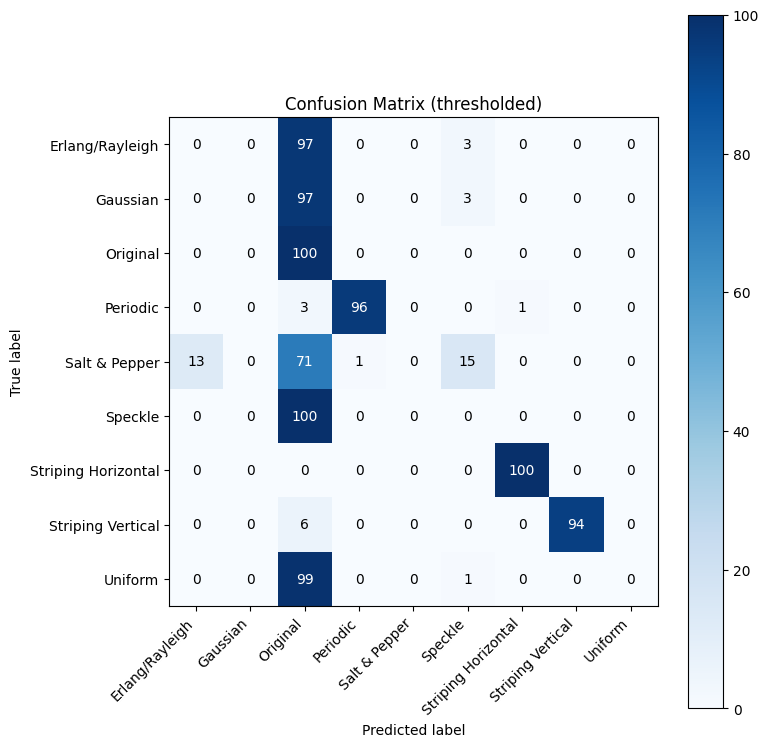

In [8]:
# --- CONFUSION MATRIX (thresholded) ---
cm = confusion_matrix(y_true, y_pred_thresh, labels=class_names)

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (thresholded)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Annotazioni dei valori dentro la matrice
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()